# Генерация текста с помощью RNN


In [1]:
import os
import re

from IPython.display import clear_output
from random import sample

import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evagolubenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [2]:
with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' '+line.lower() for line in quotes]

In [21]:
quotes[80:110]

[" i often feel that my days in new york city, that i was here for five years, didn't get one job, went on a thousands of auditions and literally did not get a job on a soap, not a movie, not tv, not nothing, although i did do some commercials thank god.",
 " it seems to me if you want something badly enough, whether you're a man or a woman, you'll do whatever you have to do to get it.",
 " yeah, but there's nobody who represents romance to me like cary grant.",
 ' a film has its own life and takes its own time.',
 " but then, even with sex, i'm more in the school of less is more in movies.",
 ' i think every actor wants to be an fbi or cop at one point.',
 " i'm sort of fascinated by the whole espionage crime thing.",
 " if we're talking about masculinity and tenderness, i don't look at clinton.",
 " the f.b.i. is about nuts and bolts. it's all about witnesses and procedure and walking the streets.",
 ' i think they are very important because westerns have a code and a symbolism.',
 "

Посмотрим на распределение длин имен:

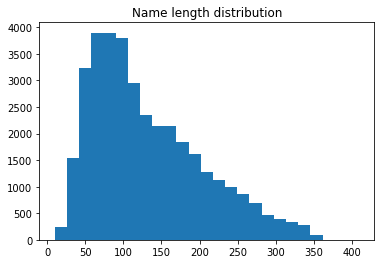

In [4]:
plt.title('Name length distribution')
plt.hist(list(map(len, quotes)), bins=25);

# Препроцессинг

In [5]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [17]:
tokens

['g',
 '.',
 ' ',
 'j',
 '5',
 'a',
 'e',
 '=',
 '?',
 '/',
 'd',
 '#',
 '8',
 'i',
 '$',
 'q',
 'y',
 '-',
 'u',
 '6',
 'o',
 '3',
 '&',
 ')',
 'x',
 ':',
 '4',
 'k',
 '7',
 'l',
 ';',
 ',',
 '£',
 '0',
 'b',
 'r',
 'f',
 '*',
 '!',
 '9',
 '—',
 '+',
 '"',
 'c',
 'z',
 '’',
 'm',
 '1',
 '2',
 'p',
 'h',
 't',
 'n',
 '(',
 '%',
 's',
 "'",
 'v',
 'w']

def preproc(list_sentences):
    
    quotes_tok = []
    for i in list_sentences:
        i = re.sub('[^a-zA-Z\-\']', ' ', i)
        i = re.sub(' +', ' ', i)
        quotes_tok.append(i)
    return quotes_tok

quotes_sent = preproc(quotes)

quotes_tok = ''.join(quotes_sent).split()

tokens = list(set(quotes_tok))
num_tokens = len(tokens)

In [6]:
print('Количество уникальных токенов: ', num_tokens)

Количество уникальных токенов:  59


### Символы -> id

Создадим словарь < символ > -> < id >

In [8]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [9]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype)

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [24]:
len(quotes[:2])

2

In [23]:
#Example: cast 4 names to matrices, pad with zeros
print(' '.join(quotes[:2]))
print(to_matrix(quotes[:2], token_to_id))

 if you live to be a hundred, i want to live to be a hundred minus one day so i never have to live without you.  promise me you'll always remember: you're braver than you believe, and stronger than you seem, and smarter than you think.
[[ 2 13 36  2 16 20 18  2 29 13 57  6  2 51 20  2 34  6  2  5  2 50 18 52
  10 35  6 10 31  2 13  2 58  5 52 51  2 51 20  2 29 13 57  6  2 51 20  2
  34  6  2  5  2 50 18 52 10 35  6 10  2 46 13 52 18 55  2 20 52  6  2 10
   5 16  2 55 20  2 13  2 52  6 57  6 35  2 50  5 57  6  2 51 20  2 29 13
  57  6  2 58 13 51 50 20 18 51  2 16 20 18  1  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 2 49 35 20 46 13 55  6  2 46  6  2 16 20 18 56 29 29  2  5 29 58  5 16
  55  2 35  6 46  6 46 34  6 35 25  2 16 20 18 56 35  6  2 34 35  5 57  6
  35  2 51 50  5 52  2 16 20 18  2 34  6 29 13  6 57  6 31  2  5 52 10  2
  55 51 35 20 52  0  6 35  2 51 50  5 52  2 16 20 18  2 55  6  6 46 31  2
   5 52 10  2 55 46  5 35 51  6 35  2 51 50  5 52  2 16 20 18  2 51 50 13
  52 27  1]]

# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [12]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

        
    def forward(self, x, hidden_state=None):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(self.emb(x), hidden_state)
        else:
            h_seq, new_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

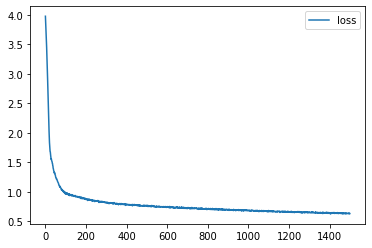

In [13]:
MAX_LENGTH = max(map(len, quotes))

for i in range(1500):
    batch_ix = to_matrix(sample(quotes, 5000), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)[0]
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [14]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [16]:
for _ in range(10):
    print(generate_sample(model))

 agct to ghayr a as tho neve moul ancoully prout ev1rold for low to on abperaptice thend is cellley, for ke aystion bateditigggod is is forfien to they is lyons wor to precuare arly my.gggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg
 my alle, dadic can suyminnts fore the toeng. they tumoud to mavery dificis.ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg
 euf gour there si muple list enronous to yougg, lifn dead of iss that arturess kom cistroce my are the hos, of's thay beceds act an pedowhre..ggggggggggggggggggggggggggggggggggggg